<a href="https://colab.research.google.com/github/comparativechrono/microscoPi/blob/main/mjpeg2bpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting heart beat data from Raspberry Pi captured mjpeg

In [2]:
pip install opencv-python numpy matplotlib scipy


This script will extract average colours from 10 second videos and calculate average heart rate

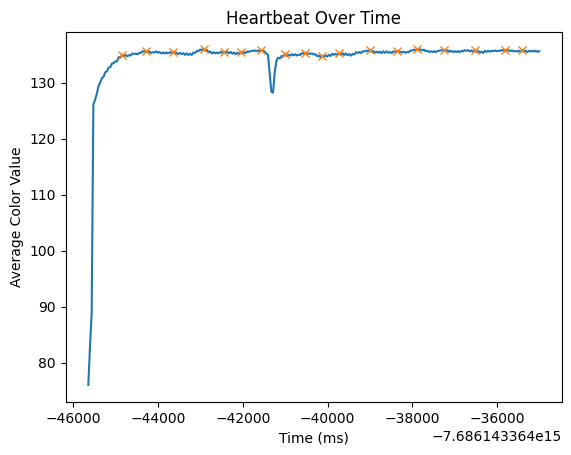

Estimated Beats Per Minute: 108


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the video
cap = cv2.VideoCapture('heart4i2r.mjpeg') # replace with your file name

average_colors = []
timestamps = []

# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Compute the average color
    average_color = np.mean(frame, axis=(0, 1))
    average_colors.append(np.mean(average_color))
    timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))

cap.release()

# Convert to numpy array for analysis
average_colors = np.array(average_colors)
timestamps = np.array(timestamps)

# Find peaks for heartbeat
peaks, _ = find_peaks(average_colors, distance=10)
# distance is crucial for accurate peak detection. It represents the minimum horizontal distance (in terms of number of frames) expected between peaks.
# You may need to experiment with this value based on the frame rate of the video and the expected rate of heartbeats.

# Plotting
plt.plot(timestamps, average_colors)
plt.plot(timestamps[peaks], average_colors[peaks], "x")
plt.title("Heartbeat Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Average Color Value")
plt.show()

# Calculate BPM
bpm = len(peaks) * 6
print(f"Estimated Beats Per Minute: {bpm}")


**Fix for noisy data.** This script will extract average colours from 10 second videos, clip off the first 2 seconds which are quite noisy, and calculate average heart rate from the remaining eight seconds.

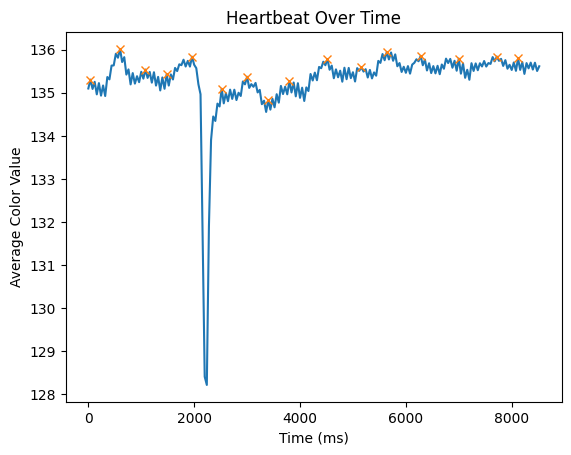

Estimated Beats Per Minute: 120.0


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the video
cap = cv2.VideoCapture('heart4i2r.mjpeg') # replace with your file name

average_colors = []
timestamps = []

# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Compute the average color
    average_color = np.mean(frame, axis=(0, 1))
    average_colors.append(np.mean(average_color))
    timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))

cap.release()

# Convert to numpy array for analysis
average_colors = np.array(average_colors)
timestamps = np.array(timestamps)

# Determine number of frames to clip
total_frames = len(average_colors)
frames_to_clip = int(total_frames * 0.2)  # 20% of the total frames

# Clip the initial noisy data
average_colors = average_colors[frames_to_clip:]
timestamps = timestamps[frames_to_clip:]

# Adjust timestamps after clipping
timestamps -= timestamps[0]

# Find peaks for heartbeat
peaks, _ = find_peaks(average_colors, distance=10)
# distance is crucial for accurate peak detection. It represents the minimum horizontal distance (in terms of number of frames) expected between peaks.
# You may need to experiment with this value based on the frame rate of the video and the expected rate of heartbeats.

# Plotting
plt.plot(timestamps, average_colors)
plt.plot(timestamps[peaks], average_colors[peaks], "x")
plt.title("Heartbeat Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Average Color Value")
plt.show()

# Calculate BPM
bpm = len(peaks) * 7.5
print(f"Estimated Beats Per Minute: {bpm}")


**Total colour method.** This method sums up the values of all pixels in each frame, which might be more sensitive to changes in the overall color intensity, potentially making it easier to detect the heartbeats.

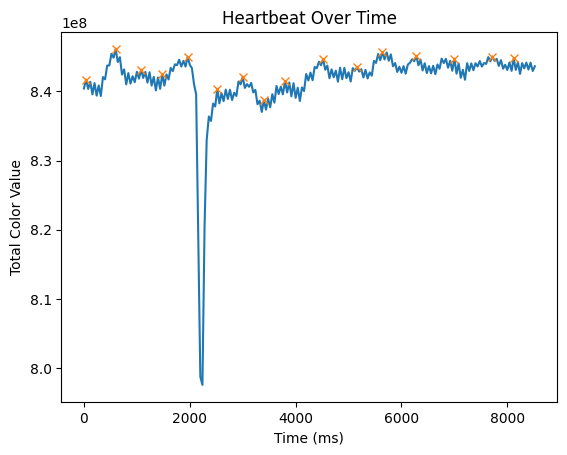

Estimated Beats Per Minute: 120.0


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the video
cap = cv2.VideoCapture('heart4i2r.mjpeg')

total_colors = []
timestamps = []

# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Compute the total color
    total_color = np.sum(frame, axis=(0, 1))
    total_colors.append(np.sum(total_color))
    timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))

cap.release()

# Convert to numpy array for analysis
total_colors = np.array(total_colors)
timestamps = np.array(timestamps)

# Determine number of frames to clip
total_frames = len(total_colors)
frames_to_clip = int(total_frames * 0.2)  # 20% of the total frames

# Clip the initial noisy data
total_colors = total_colors[frames_to_clip:]
timestamps = timestamps[frames_to_clip:]

# Adjust timestamps after clipping
timestamps -= timestamps[0]

# Find peaks for heartbeat
peaks, _ = find_peaks(total_colors, distance=10)  # Adjust parameters as needed

# Plotting
plt.plot(timestamps, total_colors)
plt.plot(timestamps[peaks], total_colors[peaks], "x")
plt.title("Heartbeat Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Total Color Value")
plt.show()

# Calculate BPM
bpm = len(peaks) * 7.5  # Adjusted for 8-second window
print(f"Estimated Beats Per Minute: {bpm}")


# Frequency Analysis (Fourier Transform)
Carries on from above. We will apply the Fourier Transform to these average color values to convert the signal from the time domain to the frequency domain:

**Read the Frame Rate from the Video File** You can use OpenCV to open the video file and read its properties.

In [13]:
import cv2

# Load the video
cap = cv2.VideoCapture('heart4i2r.mjpeg')

# Get the frame rate
fps = cap.get(cv2.CAP_PROP_FPS)

cap.release()

print("Frame rate:", fps)


Frame rate: 25.0


**Apply frequency analysis** This needs some development

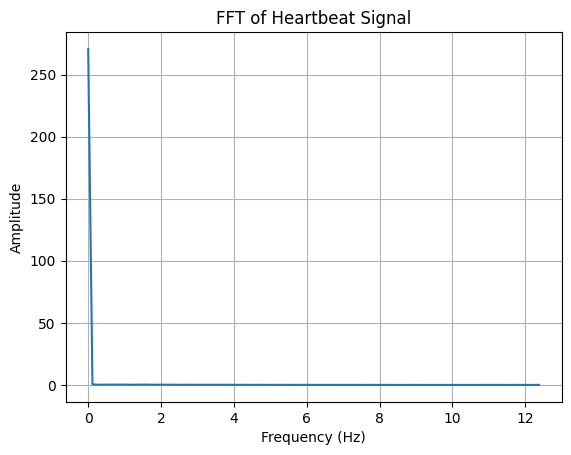

Heart Rate: 0.00 beats per minute


In [14]:
from scipy.fft import fft
from scipy.fftpack import fftfreq

# Number of samplepoints
N = len(average_colors)

# Sample spacing
T = 1.0 / fps  # Assuming a frame rate of 30 fps

yf = fft(average_colors)
xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.title("FFT of Heartbeat Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

peak_frequency_index = np.argmax(2.0/N * np.abs(yf[0:N//2]))
heart_rate_hz = xf[peak_frequency_index]
heart_rate_bpm = heart_rate_hz * 60

print(f"Heart Rate: {heart_rate_bpm:.2f} beats per minute")


# Other analysis ideas

**Python Script for Pixel Difference Analysis**  Instead of focusing on color intensity, we can analyse the frame-to-frame difference in pixel values. This method involves subtracting each frame from its predecessor and summing up the absolute values of these differences. Sudden changes in pixel values could indicate a heartbeat. I don't think this works very well.


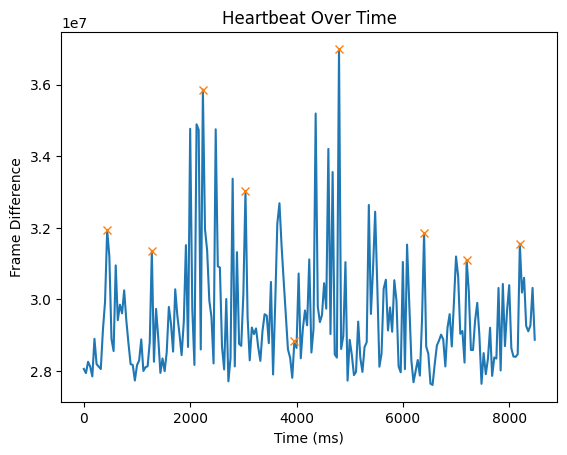

Estimated Beats Per Minute: 67.5


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load the video
cap = cv2.VideoCapture('heart4i2r.mjpeg')

frame_differences = []
timestamps = []
prev_frame = None

# Process the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if prev_frame is not None:
        # Calculate the difference
        diff = cv2.absdiff(prev_frame, frame)
        total_diff = np.sum(diff)
        frame_differences.append(total_diff)

    prev_frame = frame.copy()
    timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))

cap.release()

# Convert to numpy array for analysis
frame_differences = np.array(frame_differences)
timestamps = np.array(timestamps)

# Determine number of frames to clip
total_frames = len(frame_differences)
frames_to_clip = int(total_frames * 0.2)  # 20% of the total frames

# Clip the initial noisy data
frame_differences = frame_differences[frames_to_clip:]
timestamps = timestamps[frames_to_clip:]

# Adjust timestamps after clipping
timestamps -= timestamps[0]

# Find peaks for heartbeat
peaks, _ = find_peaks(frame_differences, distance=20)  # Adjust distance as needed

# Plotting
plt.plot(timestamps[:-1], frame_differences)  # Adjust for one less in frame differences
plt.plot(timestamps[peaks], frame_differences[peaks], "x")
plt.title("Heartbeat Over Time")
plt.xlabel("Time (ms)")
plt.ylabel("Frame Difference")
plt.show()

# Calculate BPM
bpm = len(peaks) * 7.5  # Adjusted for 8-second window
print(f"Estimated Beats Per Minute: {bpm}")


**Python Script for Optical Flow Analysis** This script uses the Farneback method for calculating the optical flow, which tracks the movement of points between two frames.


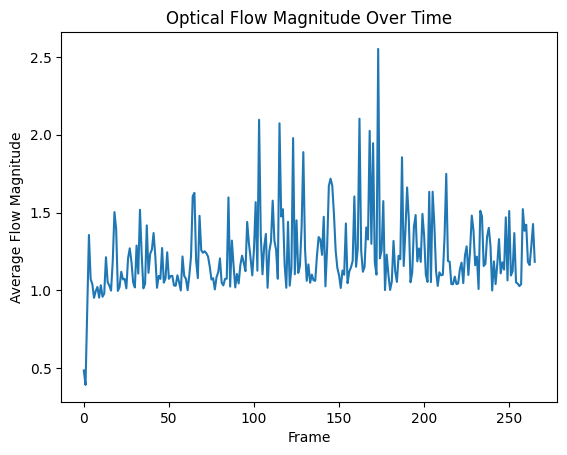

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_optical_flow(prev_frame, current_frame):
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Return the mean magnitude of flow
    return np.mean(magnitude)

# Load the video
cap = cv2.VideoCapture('heart4i2r.mjpeg')

ret, prev_frame = cap.read()
flow_magnitudes = []

# Process the video
while True:
    ret, frame = cap.read()
    if not ret:
        break

    flow_magnitude = calculate_optical_flow(prev_frame, frame)
    flow_magnitudes.append(flow_magnitude)
    prev_frame = frame

cap.release()

# Plotting the optical flow magnitudes
plt.plot(flow_magnitudes)
plt.title("Optical Flow Magnitude Over Time")
plt.xlabel("Frame")
plt.ylabel("Average Flow Magnitude")
plt.show()


**Understanding the Script**
Optical Flow Calculation: The script calculates the optical flow between consecutive frames using the Farneback method. It returns the mean magnitude of the flow, which represents the average motion in the frame.

*    Frame Processing: The video is processed frame by frame, and the optical flow magnitude is calculated for each pair of consecutive frames.

*     Plotting: The script plots the average optical flow magnitude over time. Peaks in this plot could correspond to heartbeats.